In [1]:
import hickle as hkl
import numpy as np 
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
import sys
import PIL.Image

In [3]:
def hist_norm(source, template):
    olddtype = source.dtype
    oldshape = source.shape
    source = source.ravel()
    template = template.ravel()

    '''
    # convert the input to be 0 - 256
    '''
    if source.dtype != np.int:
        source = np.trunc(source).astype(int)
        template = np.trunc(template).astype(int)
    '''
        the np.unique funcitons should be fine as long as we only do it on the masked sections
        # the np.cumsum functions are fine as well
        # the np.interp is where i'm not sure! 
    '''
    s_values, bin_idx, s_counts = np.unique(source, return_inverse=True,
                                            return_counts=True)
    t_values, t_counts = np.unique(template, return_counts=True)

    s_quantiles = np.cumsum(s_counts).astype(np.float64)
    s_quantiles /= s_quantiles[-1]
    t_quantiles = np.cumsum(t_counts).astype(np.float64)
    t_quantiles /= t_quantiles[-1]
    interp_t_values = np.interp(s_quantiles, t_quantiles, t_values)

    return interp_t_values[bin_idx].reshape(oldshape)

In [4]:
reference = PIL.Image.open("../references/screenshots/brazil-storymap2.png")
target =  np.array(PIL.Image.open("../references/screenshots/brazil-storymap1.png"))
reference = np.array(reference)

In [5]:
adjusted = np.copy(reference)
for band in range(0, 3):
    adjusted[..., band] = hist_norm(reference[:, :, band], target[:, :, band])
adjusted = PIL.Image.fromarray(adjusted[..., :3])
adjusted.show()

In [2]:
%run ../src/preprocessing/slope.py
%run ../src/preprocessing/indices.py
%run ../src/downloading/utils.py
%run ../src/preprocessing/cloud_removal.py
%run ../src/preprocessing/whittaker_smoother.py

In [170]:
folder = "../tile_data/brazil-streambank-2/2019/"
idx = "0_0"
clouds = hkl.load(folder + "raw/clouds/clouds_{}.hkl".format(idx))
sentinel2 = hkl.load(folder + "raw/s2/{}.hkl".format(idx)).astype(np.float32)
image_dates = hkl.load(folder + "raw/misc/s2_dates_{}.hkl".format(idx))
shadows = hkl.load(folder + "raw/clouds/shadows_{}.hkl".format(idx))
        
        
x, interp = remove_cloud_and_shadows(sentinel2, clouds, shadows, image_dates)
print("Clouds and shadows interpolated")    

Interpolated 1333809 px
Clouds and shadows interpolated


In [ ]:
# continue to compare the histogram matching vs median matching, 
# and then finish processing the gain data and making the slide deck for sean
# streambank 2018, 2019, small-plot, kenya, and guatemala still need to be done

In [171]:
np.sum(interp, axis = (1, 2, 3))

array([2512260.,       0.,       0.,       0., 3112430., 1664460.,
             0.,       0.,       0.,       0.,       0.,  388270.,
        196610.,  109270.,       0.,       0.,       0.,       0.,
             0., 2925200.,       0.,       0.,       0.,       0.,
             0.,       0.,       0.,       0.,       0., 1459340.,
             0.,       0.,       0.,       0.,       0.,       0.,
             0.,       0.,  797840.,       0.,       0.,       0.,
             0.,       0.,       0.,       0., 2048720.,   62220.,
             0.,       0.,  811960.,       0., 3260430.,       0.,
             0.,  526770.,   29480.,   29480.,       0.], dtype=float32)

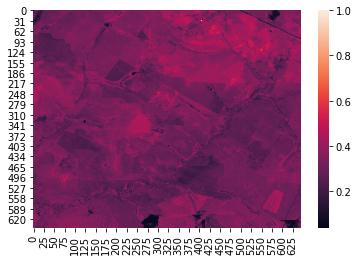

In [173]:
sns.heatmap(x[4, :, :, 3])

In [174]:
def hist_norm(source, template):
    olddtype = source.dtype
    oldshape = source.shape
    source = source.ravel()
    template = template.ravel()

    '''
    # convert the input to be 0 - 256
    '''
    if source.dtype != np.int:
        source = np.trunc(source * 256).astype(int)
        template = np.trunc(template * 256).astype(int)
        
    s_values, bin_idx, s_counts = np.unique(source, return_inverse=True,
                                            return_counts=True)
    t_values, t_counts = np.unique(template, return_counts=True)

    s_quantiles = np.cumsum(s_counts).astype(np.float64)
    s_quantiles /= s_quantiles[-1]
    t_quantiles = np.cumsum(t_counts).astype(np.float64)
    t_quantiles /= t_quantiles[-1]
    interp_t_values = np.interp(s_quantiles, t_quantiles, t_values)

    return interp_t_values[bin_idx].reshape(oldshape)

def adjust_interpolated_areas_new(array, interp):
    for time in range(array.shape[0]):
        for band in range(array.shape[-1]):
            interp_i = interp[time, :, :, band]
            array_i = array[time, :, :, band]
            if np.sum(interp_i) > 0:
                to_adjust = array_i[interp_i == 1]
                target = array_i[interp_i == 0]
                adjusted = hist_norm(to_adjust, array_i[interp_i == 0])
                adjusted = adjusted.astype(np.float32) / 256
                adjusted_idx = np.argwhere(interp_i.flatten() == 1).flatten()
                array_i = array_i.flatten()
                array_i[adjusted_idx] = adjusted
                array_i = np.reshape(array_i, (646, 646))
                array[time, :, :, band] = array_i
    return array

def adjust_interpolated_areas(array, interp):
    for time in range(array.shape[0]):
        for band in range(array.shape[-1]):
            interp_i = interp[time, :, :, band]
            array_i = array[time, :, :, band]
            if np.sum(interp_i) > 0:
                adj = (np.median(array_i[np.where(interp_i == 0)]) - 
                      (np.median(array_i[np.where(interp_i == 1)])))
                array_i[np.where(interp_i == 1)] += adj
                array[time, :, :, band] = array_i
    return array

In [175]:
x_new = np.copy(x)

In [176]:
adjust_old = adjust_interpolated_areas(x_new, interp)

In [177]:
x_new = np.copy(x)
adjust = adjust_interpolated_areas_new(x_new, interp)

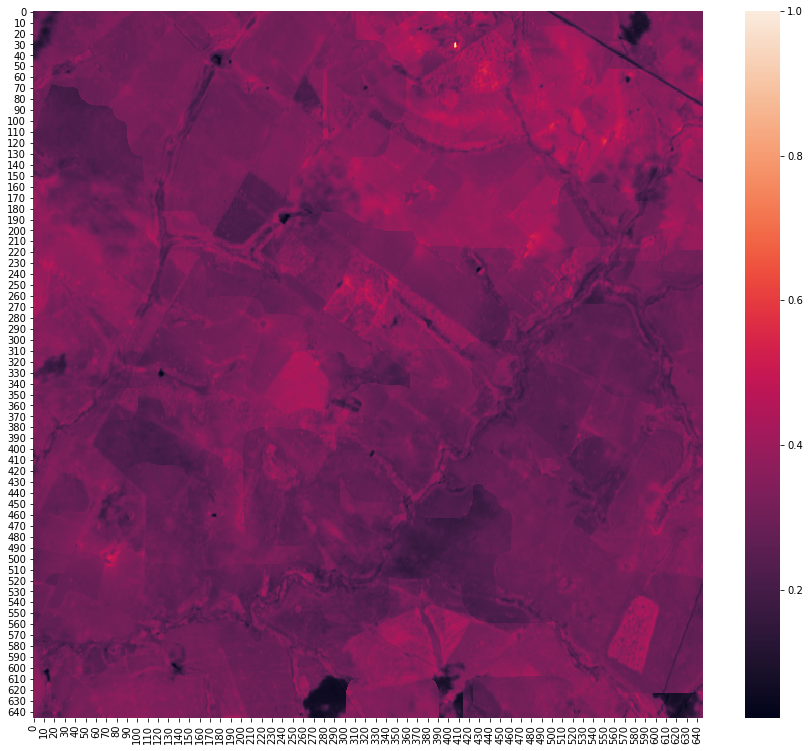

In [178]:
plt.figure(figsize=(15, 13))
sns.heatmap(adjust_old[4, :, :, 3])

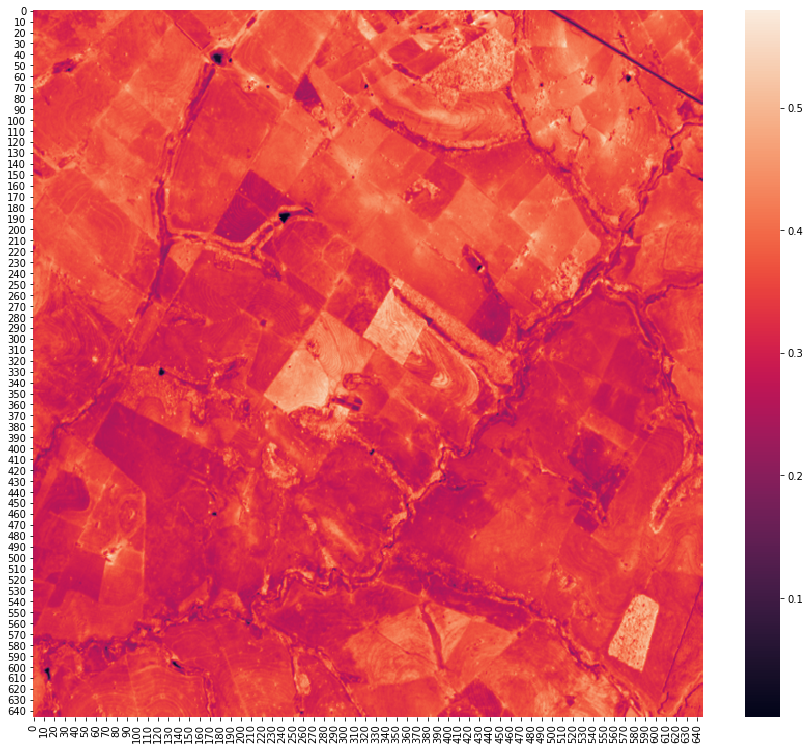

In [192]:
plt.figure(figsize=(15, 13))
sns.heatmap(adjust[6, :, :, 3])

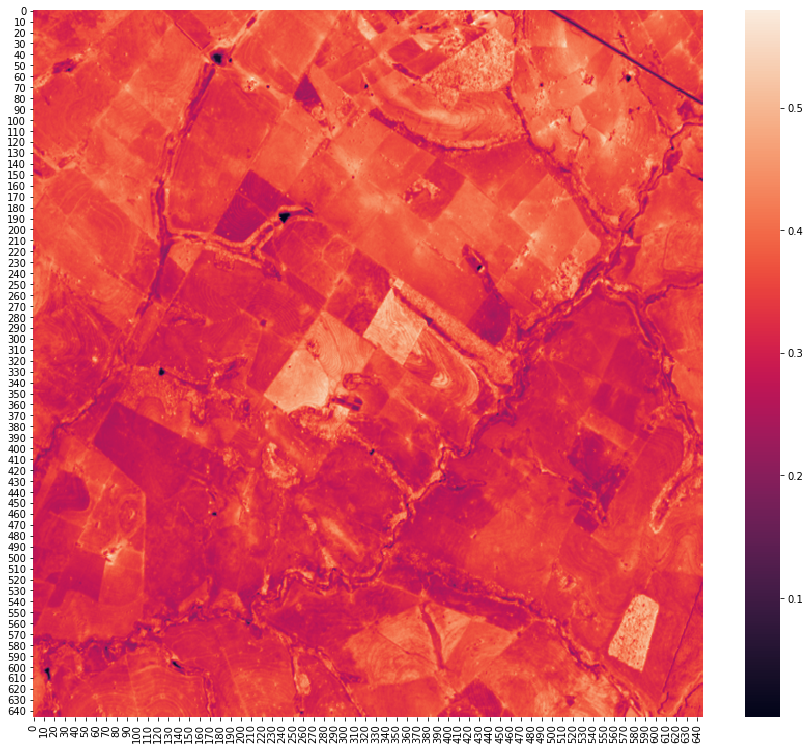

In [191]:
plt.figure(figsize=(15, 13))
sns.heatmap(x[6, :, :, 3])

In [163]:
np.sum(interp, axis = (1, 2, 3))

array([  91730., 2959170.,  533630.,   91700.,   91690.,   91690.,
       1235600.,  353200., 2957750., 3415980., 2694770.,  365350.,
       1938000.,  189880., 3492910.,  533470.,  232300.,  167000.,
        169630.,  210410.,       0., 1992300.,  131430.,  132140.,
        277000.,  335200.,  444250.,   90270.,   90810., 2531970.],
      dtype=float32)

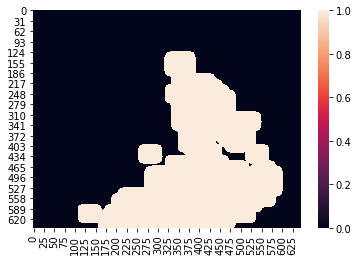

In [105]:
sns.heatmap(interp[17, :, :, 0])